last update: 2021/12/02   
created: : 2021/07/20  

<!-- 
written with reference to :  
"exojax/examples/testlines/line_strength_CO.py"  

cd ~/work
-->

In [1]:
from exojax.spec import moldb, atomll
from exojax.utils.grids import wavenumber_grid
import numpy as np
import jax.numpy as jnp
from jax import vmap, jit
from exojax.spec import SijT

#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt

Set the path to save figures (optional)

In [2]:
#import pathlib
#path_fig = pathlib.Path('~/Dropbox/tmpfig')#('/home/tako/work/fig')

In [3]:
N=1000
nus,wav,res = wavenumber_grid(10380, 10430, N, unit="AA") 

valdlines = '/home/tako/work/VALD3/HiroyukiIshikawa.4214450.gz'
"""
    valdlines:  fullpath to the input line list obtained from VALD3 (http://vald.astro.uu.se/):
            VALD data access is free but requires registration through the Contact form (http://vald.astro.uu.se/~vald/php/vald.php?docpage=contact.html). After the registration, you can login and choose the "Extract Element" mode.
        For a example in this notebook, the request form of "Extract All" mode was filled as:
          Extract All
            Starting wavelength :    10380
            Ending wavelength :    10430
            Extraction format :    Long format
            Retrieve data via :    FTP
            (Hyperfine structure:    N/A)
            (Require lines to have a known value of :    N/A)
            Linelist configuration :    Default
            Unit selection:    Energy unit: eV - Medium: vacuum - Wavelength unit: angstrom - VdW syntax: default
        Please assign the fullpath of the output file sent by VALD ([user_name_at_VALD].[request_number_at_VALD].gz;  "vald2600.gz" in the code below) to the variable "valdlines".
        Note that the number of spectral lines that can be extracted in a single request is limited to 1000 in VALD (https://www.astro.uu.se/valdwiki/Restrictions%20on%20extraction%20size).
"""

adbFe=moldb.AdbVald(valdlines, nus, crit=1.e-46)

xsmode assumes ESLOG: mode= lpf
Reading VALD file


In [4]:
Tarr=jnp.logspace(jnp.log10(800),jnp.log10(1700),100)

#interpolated partition function ratio
qt_284=vmap(adbFe.QT_interp_284)(Tarr)
qt = np.zeros([len(adbFe.QTmask), len(Tarr)])
for i, mask in enumerate(adbFe.QTmask):
    qt[i] = qt_284[:,mask]  #e.g., qt_284[:,76] #Fe I
qt = jnp.array(qt)

SijM=jit(vmap(SijT,(0,None,None,None,0)))\
    (Tarr, adbFe.logsij0, adbFe.nu_lines, adbFe.elower, qt.T)

In [5]:
imax=jnp.argmax(SijM,axis=0)
Tmax=Tarr[imax]

#test
#from exojax.spec import planck
#pl=planck.piBarr(jnp.array([1100.0,1000.0]),nus)
#print(pl[1]/pl[0])

In [6]:
#check element
print(adbFe.ielem)
print(np.min(Tmax))

[90 21 21 22 65 22 22 22 22 65]
1135.5233


In [7]:
from exojax.spec.atomllapi import PeriodicTable

lab = list(map(lambda x: PeriodicTable[x], adbFe.ielem ))
print(lab)

['Th', 'Sc', 'Sc', 'Ti', 'Tb', 'Ti', 'Ti', 'Ti', 'Ti', 'Tb']


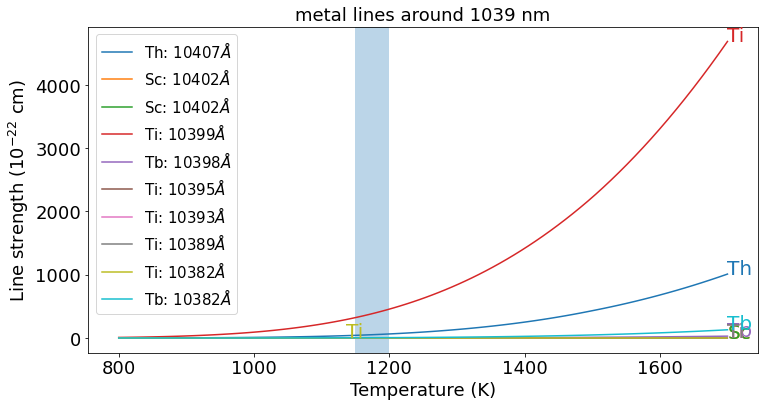

#Note that we ignore the formation of TiO


In [8]:
#lsa=["solid","dashed","dotted","dashdot"]
fac=1.e22
fig=plt.figure(figsize=(12,6))
#for i in range(len(mdbM.A)):
#    j=0
for j,i in enumerate(np.arange(SijM.shape[1])):
    w=lab[j]+": "+str(int(1.e8/adbFe.nu_lines[i]))+"$\\AA$"
    plt.plot(Tarr,SijM[:,i]*fac,alpha=1.0,label=w) #,ls=lsa[j]
    plt.text(Tmax[i],SijM[imax[i],i]*fac-(1-j)*0.3,lab[j],fontsize=20,color="C"+str(j))

#    w=str(int(1.e8/mdbM.nu_lines[i]*(1.0+28.0/300000.)))+"AA"+" i="+str(i)
#    plt.plot(Tarr,SijM[:,i]*fac,color="C"+str(j),ls=lsa[j],alpha=1.0,label=w)
#    plt.text(Tmax[i],SijM[imax[i],i]*fac-(1-j)*0.01*i,str(i),fontsize=20,color="C"+str(j))

    #plt.axvspan(1000.0,1100.0,alpha=0.3)
plt.axvspan(1150.0,1200.0,alpha=0.3)

plt.legend(loc='upper left', fontsize=15)

plt.tick_params(labelsize=18)
plt.xlabel("Temperature (K)",fontsize=18)
plt.ylabel("Line strength ($10^{-22}$ cm)",fontsize=18)
plt.title("metal lines around 1039 nm",fontsize=18)
#plt.savefig(path_fig/"lsco.png", bbox_inches="tight", pad_inches=0.0)
#plt.savefig(path_fig/"lsvald3.pdf", bbox_inches="tight", pad_inches=0.0)
plt.show()

print("#Note that we ignore the formation of TiO") #%\\\\20210817
